### The three sources of errors

Machine Learning 모델은 대개 세가지 오류 때문에 애를 먹는다

1. **bias** : 이 오류는 비현실적인 가정에서 비롯된다. 편향이 너무 크면 machine learning 알고리즘이 특성과 결과 간의 중요한 관계를 인식하는 데 실패한다. 이 상황에 알고리즘이 `underfitting`되었다고 한다.
2. **variance** : 이 오류는 훈련 데이터의 작은 변화에 대한 민감도에서 비롯된다. 분산이 높으면 알고리즘은 훈련 데이터셋을 과적합한 것이며, 이로인해 훈련 데이터셋의 아주 작은 변화에 대해서도 완전히 다른 예측을 할 수 있다. 훈련 데이터셋의 일반적인 패턴을 모델링하는 대신, 알고리즘은 신호를 잡음으로 간주한다.
3. **noise** : 예측하지 못한 변화나 측정 오류와 같은 관측값의 분산 때문에 발생한다. 더 이상 줄일 수 없는 오류이므로 어떤 모델로도 해결하지 못한다.

관측값 $(x_i)_{i=1, \dots, n}$의 훈련 데이터셋과 실수값 결과 $(y_i)_{i=1,\dots,n}$이 있다고 가정하자. 함수 $f[x]$가 있으며, $y = f[x] + \epsilon$이며, 여기서 $\epsilon$이며, 여기서 $\epsilon$은 $E[\epsilon_i] = 0$이고, $E[\epsilon_i^2] = \sigma_\epsilon^2$인 백색 잡음이다. 
$f[x]$를 가장 잘 적합화하는 함수 $\hat{f[x]}$를 추정하는데, 예측 오차의 분산을 최소화하는 방법을 활용한다. 이 평균 오차는 다음처럼 분해할 수 있다.

$$E \left[(y_i - \hat{f[x_i]})^2 \right] = \left(\left[ E[\hat{f[x_i]} - f[x_i]]\right]\right) + V\left[\hat{f[x_i]} \right] + \sigma_\epsilon^2$$

Ensemble methods는 일련의 모두 같은 학습 알고리즘을 기반으로 하는 약한 학습기들을 병합함으로써 개별 학습기보다 더 좋은 성능을 발휘하는 학습기를 생성하는 것이다. Ensemble method는 편향 또는 분산을 축소하는데 도움을 준다


### Bagging

배깅은 예측 시 분산을 축소하는 효과적인 방법이다. 다음과 같이 작동한다

1. 복원 랜덤 표본 추출(Bootstrapping)을 통해 N개의 훈련 데이터셋을 생성한다
2. 각각의 훈련 데이터셋에 적합화된 N개 추청 계수를 구한다. 이 추정 계수들은 각각 독립적으로 적합화되므로 모델들은 병렬로 적합화할 수 있다.
3. 앙상블 예측은 N모댈로부터 생성된 각 개별 예측의 단순 평균이다. 범주형 변수의 경우 관측치가 어떤 클래스에 속할 확률은 관측을 그 클래스 멤버로 분류한 추정기의 비율로 계산한다. 기초 추정기가 예측 확률을 갖고 예측할 수 있으면 배깅 분류기는 확률의 평균을 도출할 수 있다.

#### 분산 축소

배깅의 주요 장점은 예측의 분산을 줄이는 것이다. 그러므로 과적합을 해결하는 데 도움이 된다. 배깅된 예측의 분산은 배깅된 추정 계수, 단일 추정 계수 예측의 평균, 분산, 그리고 이들 예측 간의 평균 상관관계의 함수다

$$
V \left[ \frac{1}{N} \sum_{i=1}^N \varphi_i[c]\right] = \frac{1}{N^2}\sum_{i=1}^N \left( \sum_{j=1}^N \sigma_{i,j}\right)
= \frac{1}{N^2} \sum_{i=1}^N \left( \sigma_i^2 + \sum_{j \neq i}^N \sigma_i \sigma_j \rho_{i,j}\right) \\
 = \frac{1}{N^2} \sum_{i=1}^N \left( \bar{\sigma}^2 + \sum_{j \neq i}^N  \bar_{\sigma} ^2 \bar{\rho}\right)
 = \frac{\bar{\sigma}^2 + (N-1)\bar{\sigma}^2 \bar{\rho}}{N} \\
 = \bar{\sigma}^2 \left( \bar {\rho} + \frac{1 - \bar{\rho}}{N}\right)
$$

In [12]:
import numpy as np
import pandas as pd

def ensemble_variance(N, sigma_bar, rho_bar):
    variance = sigma_bar**2 * (rho_bar + (1 - rho_bar) / N)
    return variance

N_range = range(5, 51)
rho_range = np.linspace(0, 1, 101)
sigma_bar = 1  

results = pd.DataFrame(columns = np.round(rho_range, 2), index = N_range[::-1])

In [13]:
for N in N_range:
    for rho_bar in rho_range:
        variance = ensemble_variance(N, sigma_bar, rho_bar)
        results.loc[N, np.round(rho_bar, 2)] = variance

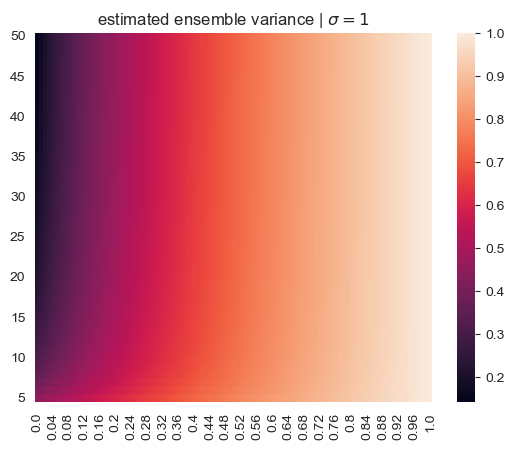

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(np.sqrt(results.astype(float)))
plt.yticks(
    ticks=np.arange(0, len(results.index), 5) + 0.5, 
    labels=results.index[::5],
    rotation = 0
)
plt.title(r'estimated ensemble variance | $\sigma = 1$')
plt.show()

#### 개선된 정확도

N개의 독립된 분류 기간의 다수결에 의해 k개 클래스를 예측하는 배깅 분류기를 생각해 보자. 예측은 {0,1}로 labeling할 수 있는데, 여기서 1은 정확한 예측을 의미한다. 분류기의 정확도는 예측을 1로 labeling하는 확률 $p$이다. 평균적으로 $Np$ 예측이 1로 labeling될 것이고, 분산은 $Np(1-p)$이다. 

In [2]:
from scipy.special import comb

N,p,k = 100, 1/3, 3.0
p_ = 0
for i in range(0, int(N/k) + 1) :
    p_ += comb(N,i) * p ** i * (1 - p) ** (N-i)
print(p)

0.3333333333333333


In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
prob_matrix = pd.DataFrame(
    index = range(101, 1, -1), 
    columns = np.arange(0.2, 0.8, 0.001).round(3)
)
for p in tqdm(np.arange(0.2, 0.8, 0.001).round(3)) :
    for n in range(1, 101) :
        k = 2
        p_ = 0
        for i in range(0, int(n/k) + 1) :
            p_ += comb(n,i) * p ** i * (1 - p) ** (n-i)
        prob_matrix.loc[n, p] = 1 - p_

100%|██████████| 601/601 [00:09<00:00, 64.16it/s]


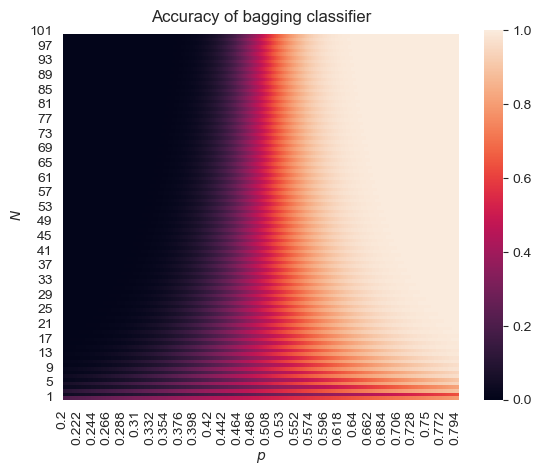

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(prob_matrix.astype(float))
plt.title('Accuracy of bagging classifier')
plt.grid(False)
plt.xlabel(r'$p$')
plt.ylabel(r'$N$')
plt.show()